In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
#from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
#from keras.applications.inception_v3 import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

NameError: name 'mixed_precision' is not defined

In [ ]:
train_dir = "F:/sc/chest_xray/train"
validation_dir = "F:/sc/chest_xray/val"
#test_dir = "C:/Users/DELL/Desktop/Brain/Data/small/test"
test_dir = "F:/sc/chest_xray/test"


In [ ]:
model1 = InceptionV3(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
input_shape = (224,224)

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 8
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 4686 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


In [ ]:
print(model1.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
def print_layer_trainable():
    for layer in model1.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	conv2d
True:	batch_normalization
True:	activation
True:	conv2d_1
True:	batch_normalization_1
True:	activation_1
True:	conv2d_2
True:	batch_normalization_2
True:	activation_2
True:	max_pooling2d
True:	conv2d_3
True:	batch_normalization_3
True:	activation_3
True:	conv2d_4
True:	batch_normalization_4
True:	activation_4
True:	max_pooling2d_1
True:	conv2d_8
True:	batch_normalization_8
True:	activation_8
True:	conv2d_6
True:	conv2d_9
True:	batch_normalization_6
True:	batch_normalization_9
True:	activation_6
True:	activation_9
True:	average_pooling2d
True:	conv2d_5
True:	conv2d_7
True:	conv2d_10
True:	conv2d_11
True:	batch_normalization_5
True:	batch_normalization_7
True:	batch_normalization_10
True:	batch_normalization_11
True:	activation_5
True:	activation_7
True:	activation_10
True:	activation_11
True:	mixed0
True:	conv2d_15
True:	batch_normalization_15
True:	activation_15
True:	conv2d_13
True:	conv2d_16
True:	batch_normalization_13
True:	batch_normalization_16
True:	ac

In [ ]:
transfer_layer = model1.get_layer('mixed10')
conv_model = Model(inputs=model1.input, outputs=transfer_layer.output)

In [ ]:
from tensorflow.keras.models import Sequential
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
#new_model.add(Sequential(tf.keras.layers.Dense(3))) 
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.

new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#new_model.add(Dense(512, activation='relu'))


# Add the final layer for the actual classification.
new_model.add(Dense(2, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate=1e-5)
loss = 'binary_crossentropy'
metrics = ['categorical_accuracy']
#name="binary_crossentropy"
#metrics=[tf.keras.metrics.BinaryAccuracy(),
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

In [ ]:
from keras.callbacks import Callback
weights = {0:3.37, 1:1}
epochs = 25

# from keras.callbacks import ModelCheckpoint
# filepath = r'/content/drive/MyDrive/Colab Notebooks/Shawon/New folder (5)/resnet-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only = True, mode='max', )

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

#steps_per_epoch = 20
#steps_test = 100
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,class_weight = weights,
                                  # callbacks = [checkpoint],
                                  )

<ipython-input-13-842df0251b73>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(generator=generator_train,


Epoch 1/25
585/585 [==============================] - 885s 1s/step - loss: 0.5001 - categorical_accuracy: 0.8664 - val_loss: 0.3939 - val_categorical_accuracy: 0.8481
Epoch 2/25
585/585 [==============================] - 884s 2s/step - loss: 0.2864 - categorical_accuracy: 0.9328 - val_loss: 0.3070 - val_categorical_accuracy: 0.8805
Epoch 3/25
585/585 [==============================] - 890s 2s/step - loss: 0.2078 - categorical_accuracy: 0.9490 - val_loss: 0.5823 - val_categorical_accuracy: 0.8464
Epoch 4/25
585/585 [==============================] - 895s 2s/step - loss: 0.1816 - categorical_accuracy: 0.9595 - val_loss: 0.5174 - val_categorical_accuracy: 0.8840
Epoch 5/25
585/585 [==============================] - 899s 2s/step - loss: 0.1476 - categorical_accuracy: 0.9631 - val_loss: 0.6258 - val_categorical_accuracy: 0.8618
Epoch 6/25
585/585 [==============================] - 899s 2s/step - loss: 0.1352 - categorical_accuracy: 0.9682 - val_loss: 0.5544 - val_categorical_accuracy: 0.863

In [ ]:
new_model.save_weights('F:/sc/chest_xray/vgg16.h5')

In [ ]:
new_model1 = new_model.load_weights('F:/sc/chest_xray/vgg16.h5')

In [ ]:
finaltestCNV_dir = "F:/sc/chest_xray/val"
datagen_finaltestCNV_dir = ImageDataGenerator(rescale=1./255)

generator_finaltestCNV_dir = datagen_finaltestCNV_dir.flow_from_directory(directory=finaltestCNV_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
steps_finaltestCNV_dir = generator_finaltestCNV_dir.n / batch_size
y_pred = new_model.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)

Found 584 images belonging to 2 classes.


<ipython-input-16-eb83555ee9a4>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = new_model.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)


In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
#print(predicted_class_indices[0:585])

In [ ]:
unique, frequency = np.unique(predicted_class_indices, 
                              return_counts = True)
# print unique values array
print("Unique Values:", 
      unique)
  
# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [0 1]
Frequency Values: [288 296]


In [ ]:
#print(predicted_class_indices[:9])

In [ ]:
#print(predicted_class_indices[9:292])

In [ ]:
print("Accuracy = ", (20/25)*100)

Accuracy =  80.0


In [ ]:
y_true = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
              
         ]

In [ ]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_true, predicted_class_indices)

In [ ]:
#array=[[15,1],[4,5]]

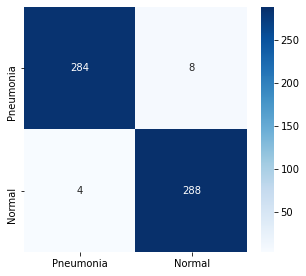

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(array, index = ["Pneumonia", "Normal"],
                  columns = ["Pneumonia", "Normal"])
plt.figure(figsize = (5,4.5))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.savefig('F:/sc/chest_xray/confusion.pdf')  

In [ ]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import lime
from lime import lime_image
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def xAI(model,img_dir):
    image = Image.open(img_dir)
    imgx = np.asarray(image)
    #print(imgx[:,:,0].shape)
    imgx = image.resize((224, 224))
    img = np.asarray(imgx)
    img = img/255
    img2 = np.zeros( ( np.array(img).shape[0], np.array(img).shape[1], 3 ) )
    img2[:,:,0] = img # same value in each channel
    img2[:,:,1] = img
    img2[:,:,2] = img
    #print(img2.shape)
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(img2, new_model.predict, labels=["Normal", "Pneumonia"],top_labels=2, hide_color=0,num_samples=1000)
    #plt.imshow(img)
    image, mask = explanation.get_image_and_mask(
             model.predict(img2.reshape((1,224,224,3))).argmax(axis=1)[0],
        
             positive_only=False,
        #num_features=10,
             hide_rest=False)
    plt.axis ('off')
    plt.imshow(mark_boundaries(image, mask))
    plt.savefig('F:/sc/chest_xray/lime124true.png')
    plt.savefig('F:/sc/chest_xray/lime124true.pdf')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step


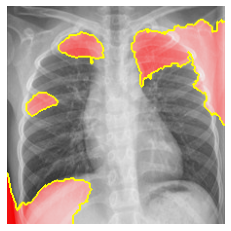

In [ ]:
#0-0
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0006-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


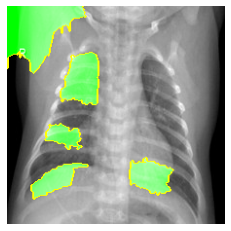

In [ ]:
#0-0
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0083-0001.jpeg")

In [ ]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

NameError: name 'image_path' is not defined

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


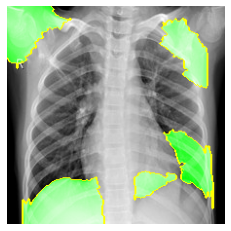

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0180-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step


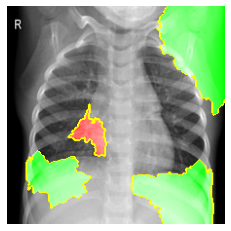

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0189-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step


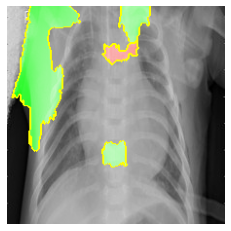

In [ ]:
#actual-1
#predict-0
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person299_bacteria_1414.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


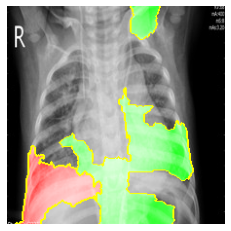

In [ ]:
#actual-1
#predict-0
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person1310_bacteria_3302.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


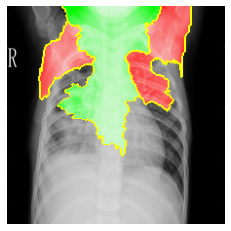

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step


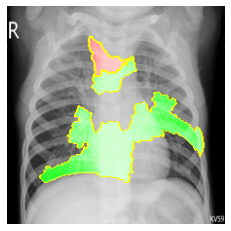

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person1396_virus_2399.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


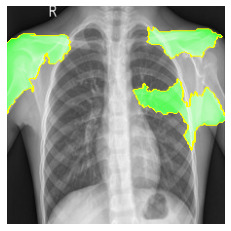

In [ ]:
#0-0
xAI(new_model, "F:/sc/chest_xray/test/NORMAL/IM-0001-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step


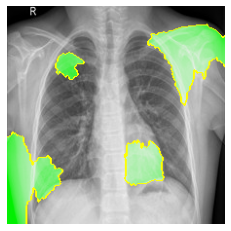

In [ ]:
#0-0
xAI(new_model, "F:/sc/chest_xray/test/NORMAL/IM-0027-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 95ms/step


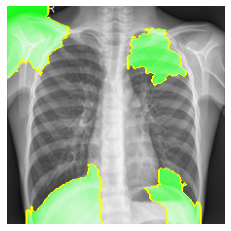

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/test/Normal/IM-0007-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 92ms/step


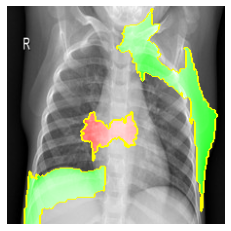

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/test/Normal/IM-0069-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step


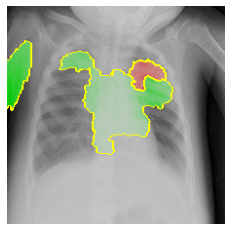

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/chest_xray/test/Pneumonia/person1682_virus_2899.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step


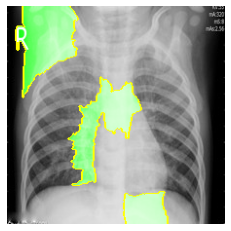

In [ ]:
#actual-1
#predict-1CORRect
xAI(new_model, "F:/sc/chest_xray/test/Pneumonia/person1673_virus_2889.jpeg")

In [ ]:
from PIL import Image
# Open the image form working directory
image = Image.open('F:/sc/chest_xray/test/PNEUMONIA/person34_virus_76.jpeg')
image = image.resize((224, 224))
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

data = np.asarray(image)

data = data/255

data2 = np.zeros( ( np.array(data).shape[0], np.array(data).shape[1], 3 ) )
data2[:,:,0] = data # same value in each channel
data2[:,:,1] = data
data2[:,:,2] = data
print(data2.shape)
y = new_model.predict(data2.reshape(1,224,224,3))

predicted_class_indices=np.argmax(y,axis=1)
print(predicted_class_indices)

None
(224, 224)
L
(224, 224, 3)
1/1 [==============================] - 0s 75ms/step
[1]


In [ ]:
Epoch 1/25
585/585 [==============================] - 885s 1s/step - loss: 0.5001 - categorical_accuracy: 0.8664 - val_loss: 0.3939 - val_categorical_accuracy: 0.8481
Epoch 2/25
585/585 [==============================] - 884s 2s/step - loss: 0.2864 - categorical_accuracy: 0.9328 - val_loss: 0.3070 - val_categorical_accuracy: 0.8805
Epoch 3/25
585/585 [==============================] - 890s 2s/step - loss: 0.2078 - categorical_accuracy: 0.9490 - val_loss: 0.5823 - val_categorical_accuracy: 0.8464
Epoch 4/25
585/585 [==============================] - 895s 2s/step - loss: 0.1816 - categorical_accuracy: 0.9595 - val_loss: 0.5174 - val_categorical_accuracy: 0.8840
Epoch 5/25
585/585 [==============================] - 899s 2s/step - loss: 0.1476 - categorical_accuracy: 0.9631 - val_loss: 0.6258 - val_categorical_accuracy: 0.8618
Epoch 6/25
585/585 [==============================] - 899s 2s/step - loss: 0.1352 - categorical_accuracy: 0.9682 - val_loss: 0.5544 - val_categorical_accuracy: 0.8635
Epoch 7/25
585/585 [==============================] - 901s 2s/step - loss: 0.1185 - categorical_accuracy: 0.9725 - val_loss: 0.6641 - val_categorical_accuracy: 0.8635
Epoch 8/25
585/585 [==============================] - 901s 2s/step - loss: 0.1006 - categorical_accuracy: 0.9720 - val_loss: 0.6437 - val_categorical_accuracy: 0.8686
Epoch 9/25
585/585 [==============================] - 901s 2s/step - loss: 0.0849 - categorical_accuracy: 0.9812 - val_loss: 0.6636 - val_categorical_accuracy: 0.8635
Epoch 10/25
585/585 [==============================] - 901s 2s/step - loss: 0.0870 - categorical_accuracy: 0.9810 - val_loss: 0.8598 - val_categorical_accuracy: 0.8208
Epoch 11/25
585/585 [==============================] - 912s 2s/step - loss: 0.0681 - categorical_accuracy: 0.9851 - val_loss: 0.6778 - val_categorical_accuracy: 0.8754
Epoch 12/25
585/585 [==============================] - 944s 2s/step - loss: 0.0697 - categorical_accuracy: 0.9836 - val_loss: 0.9004 - val_categorical_accuracy: 0.8430
Epoch 13/25
585/585 [==============================] - 919s 2s/step - loss: 0.0579 - categorical_accuracy: 0.9880 - val_loss: 0.7505 - val_categorical_accuracy: 0.8618
Epoch 14/25
585/585 [==============================] - 947s 2s/step - loss: 0.0733 - categorical_accuracy: 0.9853 - val_loss: 0.6975 - val_categorical_accuracy: 0.8686
Epoch 15/25
585/585 [==============================] - 942s 2s/step - loss: 0.0655 - categorical_accuracy: 0.9848 - val_loss: 0.7416 - val_categorical_accuracy: 0.8498
Epoch 16/25
585/585 [==============================] - 944s 2s/step - loss: 0.0503 - categorical_accuracy: 0.9880 - val_loss: 0.9374 - val_categorical_accuracy: 0.8413
Epoch 17/25
585/585 [==============================] - 935s 2s/step - loss: 0.0571 - categorical_accuracy: 0.9895 - val_loss: 0.9661 - val_categorical_accuracy: 0.8396
Epoch 18/25
585/585 [==============================] - 932s 2s/step - loss: 0.0392 - categorical_accuracy: 0.9915 - val_loss: 0.9757 - val_categorical_accuracy: 0.8294
Epoch 19/25
585/585 [==============================] - 928s 2s/step - loss: 0.0352 - categorical_accuracy: 0.9908 - val_loss: 1.0706 - val_categorical_accuracy: 0.8447
Epoch 20/25
585/585 [==============================] - 909s 2s/step - loss: 0.0329 - categorical_accuracy: 0.9913 - val_loss: 1.1438 - val_categorical_accuracy: 0.8413
Epoch 21/25
585/585 [==============================] - 908s 2s/step - loss: 0.0342 - categorical_accuracy: 0.9915 - val_loss: 0.9442 - val_categorical_accuracy: 0.8805
Epoch 22/25
585/585 [==============================] - 910s 2s/step - loss: 0.0398 - categorical_accuracy: 0.9919 - val_loss: 1.2377 - val_categorical_accuracy: 0.8447
Epoch 23/25
585/585 [==============================] - 920s 2s/step - loss: 0.0303 - categorical_accuracy: 0.9921 - val_loss: 0.9514 - val_categorical_accuracy: 0.8703
Epoch 24/25
585/585 [==============================] - 932s 2s/step - loss: 0.0289 - categorical_accuracy: 0.9930 - val_loss: 1.2028 - val_categorical_accuracy: 0.8601
Epoch 25/25
585/585 [==============================] - 916s 2s/step - loss: 0.0299 - categorical_accuracy: 0.9942 - val_loss: 1.3636 - val_categorical_accuracy: 0.8549

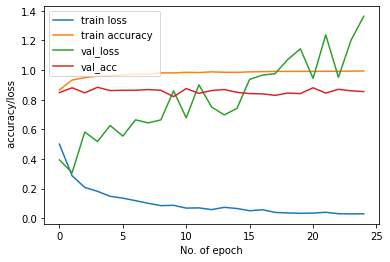

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0.5001,0.2864,0.2078,0.1816,0.1476,0.1352,0.1185,0.1006,0.0849,0.0870,0.0681,0.0697,0.0579,0.0733,0.0655,0.0503,0.0571,0.0392,0.0352,0.0329,0.0342,0.0398,0.0303,0.0289,0.0299 ])#loss
plt.plot([0.8664,0.9328,0.9490,0.9595,0.9631,0.9682,0.9725,0.9720,0.9812,0.9810,0.9851,0.9836, 0.9880,0.9853,0.9848, 0.9880,0.9895,0.9915,0.9908,0.9913,0.9915,0.9919,0.9921,0.9930,0.9942])#categorical_accuracy
plt.plot([ 0.3939, 0.3070, 0.5823, 0.5174 , 0.6258, 0.5544, 0.6641 , 0.6437 ,0.6636 ,0.8598 ,0.6778 , 0.9004, 0.7505 ,0.6975 , 0.7416 ,0.9374 ,0.9661 ,0.9757 ,1.0706,1.1438,0.9442 ,1.2377, 0.9514 ,1.2028 , 1.3636 ])#val_loss
plt.plot([0.8481,0.8805,0.8464,0.8840,0.8618,0.8635,0.8635,0.8686,0.8635,0.8208,0.8754,0.8430,0.8618,0.8686,0.8498,0.8413,0.8396,0.8294,0.8447,0.8413,0.8805,0.8447,0.8703,0.8601,0.8549])#val_categorical_accuracy
#plt.title('model accuracy and loss')
plt.ylabel(' accuracy/loss')
plt.xlabel('No. of epoch')
plt.legend(['train loss','train accuracy ', 'val_loss','val_acc'], loc='upper left')
plt.show()

In [ ]:
loss: 0.6435 - categorical_accuracy: 0.6578 - val_loss: 4.3284 - val_categorical_accuracy: 0.5000
loss: 0.3592 - categorical_accuracy: 0.8439 - val_loss: 4.7390 - val_categorical_accuracy: 0.5000
loss: 0.3245 - categorical_accuracy: 0.8740 - val_loss: 1.9577 - val_categorical_accuracy: 0.5433
loss: 0.3080 - categorical_accuracy: 0.8802 - val_loss: 1.1540 - val_categorical_accuracy: 0.6400
loss: 0.2663 - categorical_accuracy: 0.8961 - val_loss: 0.6151 - val_categorical_accuracy: 0.8000
loss: 0.2520 - categorical_accuracy: 0.8977 - val_loss: 0.2536 - val_categorical_accuracy: 0.9067
loss: 0.2271 - categorical_accuracy: 0.9157 - val_loss: 0.2361 - val_categorical_accuracy: 0.9000
loss: 0.2131 - categorical_accuracy: 0.9245 - val_loss: 0.1594 - val_categorical_accuracy: 0.9300
loss: 0.1933 - categorical_accuracy: 0.9245 - val_loss: 0.1425 - val_categorical_accuracy: 0.9500
loss: 0.2106 - categorical_accuracy: 0.9257 - val_loss: 0.1735 - val_categorical_accuracy: 0.9267
loss: 0.1738 - categorical_accuracy: 0.9320 - val_loss: 0.1375 - val_categorical_accuracy: 0.9433
loss: 0.1721 - categorical_accuracy: 0.9378 - val_loss: 0.1329 - val_categorical_accuracy: 0.9533
loss: 0.1692 - categorical_accuracy: 0.9395 - val_loss: 0.1305 - val_categorical_accuracy: 0.9500
loss: 0.1360 - categorical_accuracy: 0.9528 - val_loss: 0.1414 - val_categorical_accuracy: 0.9467
loss: 0.1312 - categorical_accuracy: 0.9578 - val_loss: 0.1156 - val_categorical_accuracy: 0.9567
loss: 0.1544 - categorical_accuracy: 0.9462 - val_loss: 0.1109 - val_categorical_accuracy: 0.9533
loss: 0.1440 - categorical_accuracy: 0.9520 - val_loss: 0.1138 - val_categorical_accuracy: 0.9567
loss: 0.1257 - categorical_accuracy: 0.9595 - val_loss: 0.1102 - val_categorical_accuracy: 0.9567
loss: 0.1233 - categorical_accuracy: 0.9574 - val_loss: 0.0947 - val_categorical_accuracy: 0.9633
loss: 0.1101 - categorical_accuracy: 0.9620 - val_loss: 0.0968 - val_categorical_accuracy: 0.9633
loss: 0.1130 - categorical_accuracy: 0.9595 - val_loss: 0.0929 - val_categorical_accuracy: 0.9633
loss: 0.1194 - categorical_accuracy: 0.9583 - val_loss: 0.1030 - val_categorical_accuracy: 0.9533
loss: 0.0946 - categorical_accuracy: 0.9679 - val_loss: 0.0954 - val_categorical_accuracy: 0.9567
loss: 0.0888 - categorical_accuracy: 0.9708 - val_loss: 0.0853 - val_categorical_accuracy: 0.9633
loss: 0.0861 - categorical_accuracy: 0.9737 - val_loss: 0.0768 - val_categorical_accuracy: 0.9733
loss: 0.0933 - categorical_accuracy: 0.9708 - val_loss: 0.0928 - val_categorical_accuracy: 0.9667
loss: 0.0877 - categorical_accuracy: 0.9670 - val_loss: 0.0843 - val_categorical_accuracy: 0.9667
loss: 0.0805 - categorical_accuracy: 0.9708 - val_loss: 0.0717 - val_categorical_accuracy: 0.9733
loss: 0.0704 - categorical_accuracy: 0.9762 - val_loss: 0.0762 - val_categorical_accuracy: 0.9767
loss: 0.0861 - categorical_accuracy: 0.9712 - val_loss: 0.0718 - val_categorical_accuracy: 0.9700
loss: 0.0716 - categorical_accuracy: 0.9741 - val_loss: 0.0655 - val_categorical_accuracy: 0.9700

SyntaxError: invalid syntax (<ipython-input-47-8873b5e9f04f>, line 1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rows = 8
columns = 7

In [ ]:
fig = plt.figure(figsize=(10, 7))

<Figure size 720x504 with 0 Axes>

In [ ]:
Image1 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0 (1)/target-0 (1).jpeg')
Image2 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0 (1)/resnetwithoutCs (1).png')
Image3 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0 (1)/resnetwithcs (1).png')
Image4 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0 (1)/inceptionwithoutCS (1).png')
Image5 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0 (1)/inceptionWithCS25e.png')
Image6 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0 (1)/VGGwithoutCS (1).png')
Image7 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0 (1)/VGGwithCS (1).png')

Imagee1 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target00 (1)/target00 (1).jpeg')
Imagee2 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target00 (1)/resnetwithoutCS.png')
Imagee3 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target00 (1)/resnetwithCS (1).png')
Imagee4 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target00 (1)/inceptionwithoutCS (1).png')
Imagee5 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target00 (1)/inceptionwithCS25e.png')
Imagee6 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target00 (1)/VGGwithoutCS (1).png')
Imagee7 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target00 (1)/VGGwithCS (1).png')


T1Image1 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0-1 (1)/IM-0180-0001 (1).jpeg')
T1Image2 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0-1 (1)/resnetwithoutCS.png')
T1Image3 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0-1 (1)/resnetwithCS (1).png')
T1Image4 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0-1 (1)/inceptionwithoutCS (1).png')
T1Image5 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0-1 (1)/inceptionwithCS25e.png')
T1Image6 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0-1 (1)/VGGwithoutCS (1).png')
T1Image7 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target 0-1 (1)/VGGwithCS (1).png')


T2Image1 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target01 (1)/IM-0189-0001 (1).jpeg')
T2Image2 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target01 (1)/resnetwithoutCS.png')
T2Image3 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target01 (1)/resnetwithCS (1).png')
T2Image4 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target01 (1)/inceptionwithoutCS (1).png')
T2Image5 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target01 (1)/inceptionwithCS25e.png')
T2Image6 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target01 (1)/VGGwithoutCS (1).png')
T2Image7 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target01 (1)/VGGwithCS (1).png')



T3Image1 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-0 (1)/person299_bacteria_1414 (1).jpeg')
T3Image2 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-0 (1)/resnetwithoutCS.png')
T3Image3 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-0 (1)/resnetwithCS (1).png')
T3Image4 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-0 (1)/inceptionwithoutCS (1).png')
T3Image5 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-0 (1)/inceptionwithCS25e.png')
T3Image6 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-0 (1)/VGGwithoutCS (1).png')
T3Image7 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-0 (1)/VGGwithCS (1).png')




T4Image1 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target10 (1)/person1310_bacteria_3302 (1).jpeg')
T4Image2 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target10 (1)/resnetwithoutCS.png')
T4Image3 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target10 (1)/resnetwithCS (1).png')
T4Image4 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target10 (1)/inceptionwithoutCS (1).png')
T4Image5 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target10 (1)/inceptionwithCS25e.png')
T4Image6 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target10 (1)/VGGwithoutCS (1).png')
T4Image7 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target10 (1)/VGGwithCS (1).png')




T5Image1 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-1 (1)/person1396_virus_2399 (1).jpeg')
T5Image2 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-1 (1)/resnetwithoutCS.png')
T5Image3 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-1 (1)/resnetwithCS (1).png')
T5Image4 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-1 (1)/inceptionwithoutCS (1).png')
T5Image5 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-1 (1)/inceptionwithCS25e.png')
T5Image6 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-1 (1)/VGGwithoutCS (1).png')
T5Image7 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target1-1 (1)/VGGwithCS (1).png')




T6Image1 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/person1954_bacteria_4886 (1).jpeg')
T6Image2 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/resnetwithoutCS.png')
T6Image3 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/resnetwithCS (1).png')
T6Image4 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/inceptionwithoutCS (1).png')
T6Image5 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/inceptionwithCS25e.png')
T6Image6 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/VGGwithoutCS (1).png')
T6Image7 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/VGGwithCS (1).png')


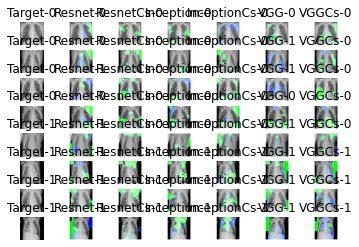

In [ ]:
#import numpy as np
from matplotlib import pyplot as plt

plt.subplot(8, 7, 1)
plt.imshow(Image1)
plt.axis('off')
plt.title("Target-0")

plt.subplot(8, 7, 2)
plt.imshow(Image2)
plt.axis('off')
plt.title("Resnet-0")

plt.subplot(8, 7, 3)
plt.imshow(Image3)
plt.axis('off')
plt.title("ResnetCs-0")

plt.subplot(8, 7, 4)
plt.imshow(Image4)
plt.axis('off')
plt.title("Inception-0")

plt.subplot(8, 7, 5)
plt.imshow(Image5)
plt.axis('off')
plt.title("InceptionCs-0")

plt.subplot(8, 7, 6)
plt.imshow(Image6)
plt.axis('off')
plt.title("VGG-0")

plt.subplot(8, 7, 7)
plt.imshow(Image7)
plt.axis('off')
plt.title("VGGCs-0")
#plt.show()

###################################################

plt.subplot(8, 7, 8)
plt.imshow(Imagee1)
plt.axis('off')
plt.title("Target-0")

plt.subplot(8, 7, 9)
plt.imshow(Imagee2)
plt.axis('off')
plt.title("Resnet-0")

plt.subplot(8, 7, 10)
plt.imshow(Imagee3)
plt.axis('off')
plt.title("ResnetCs-0")

plt.subplot(8, 7, 11)
plt.imshow(Imagee4)
plt.axis('off')
plt.title("Inception-0")

plt.subplot(8, 7, 12)
plt.imshow(Imagee5)
plt.axis('off')
plt.title("InceptionCs-0")

plt.subplot(8, 7, 13)
plt.imshow(Imagee6)
plt.axis('off')
plt.title("VGG-1")

plt.subplot(8, 7, 14)
plt.imshow(Imagee7)
plt.axis('off')
plt.title("VGGCs-0")
#plt.show()

#######################################

plt.subplot(8, 7, 15)
plt.imshow(T1Image1)
plt.axis('off')
plt.title("Target-0")

plt.subplot(8, 7, 16)
plt.imshow(T1Image2)
plt.axis('off')
plt.title("Resnet-1")

plt.subplot(8, 7, 17)
plt.imshow(T1Image3)
plt.axis('off')
plt.title("ResnetCs-0")

plt.subplot(8, 7, 18)
plt.imshow(T1Image4)
plt.axis('off')
plt.title("Inception-0")

plt.subplot(8, 7, 19)
plt.imshow(T1Image5)
plt.axis('off')
plt.title("InceptionCs-0")

plt.subplot(8, 7, 20)
plt.imshow(T1Image6)
plt.axis('off')
plt.title("VGG-1")

plt.subplot(8, 7, 21)
plt.imshow(T1Image7)
plt.axis('off')
plt.title("VGGCs-0")
#plt.show()

##############################################

plt.subplot(8, 7, 22)
plt.imshow(T2Image1)
plt.axis('off')
plt.title("Target-0")

plt.subplot(8, 7, 23)
plt.imshow(T2Image2)
plt.axis('off')
plt.title("Resnet-0")

plt.subplot(8, 7, 24)
plt.imshow(T2Image3)
plt.axis('off')
plt.title("ResnetCs-0")

plt.subplot(8, 7, 25)
plt.imshow(T2Image4)
plt.axis('off')
plt.title("Inception-0")

plt.subplot(8, 7, 26)
plt.imshow(T2Image5)
plt.axis('off')
plt.title("InceptionCs-0")

plt.subplot(8, 7, 27)
plt.imshow(T2Image6)
plt.axis('off')
plt.title("VGG-0")

plt.subplot(8, 7, 28)
plt.imshow(T2Image7)
plt.axis('off')
plt.title("VGGCs-0")
#plt.show()
###########################################

plt.subplot(8, 7, 29)
plt.imshow(T3Image1)
plt.axis('off')
plt.title("Target-1")

plt.subplot(8, 7, 30)
plt.imshow(T3Image2)
plt.axis('off')
plt.title("Resnet-1")

plt.subplot(8, 7, 31)
plt.imshow(T3Image3)
plt.axis('off')
plt.title("ResnetCs-0")

plt.subplot(8, 7, 32)
plt.imshow(T3Image4)
plt.axis('off')
plt.title("Inception-0")

plt.subplot(8, 7, 33)
plt.imshow(T3Image5)
plt.axis('off')
plt.title("InceptionCs-0")

plt.subplot(8, 7, 34)
plt.imshow(T3Image6)
plt.axis('off')
plt.title("VGG-1")

plt.subplot(8, 7, 35)
plt.imshow(T3Image7)
plt.axis('off')
plt.title("VGGCs-0")
#plt.show()
######################################

plt.subplot(8, 7, 36)
plt.imshow(T4Image1)
plt.axis('off')
plt.title("Target-1")

plt.subplot(8, 7, 37)
plt.imshow(T4Image2)
plt.axis('off')
plt.title("Resnet-1")

plt.subplot(8, 7, 38)
plt.imshow(T4Image3)
plt.axis('off')
plt.title("ResnetCs-1")

plt.subplot(8, 7, 39)
plt.imshow(T4Image4)
plt.axis('off')
plt.title("Inception-1")

plt.subplot(8, 7, 40)
plt.imshow(T4Image5)
plt.axis('off')
plt.title("InceptionCs-1")

plt.subplot(8, 7, 41)
plt.imshow(T4Image6)
plt.axis('off')
plt.title("VGG-1")

plt.subplot(8, 7, 42)
plt.imshow(T4Image7)
plt.axis('off')
plt.title("VGGCs-1")
#plt.show()
######################################

plt.subplot(8, 7, 43)
plt.imshow(T5Image1)
plt.axis('off')
plt.title("Target-1")

plt.subplot(8, 7, 44)
plt.imshow(T5Image2)
plt.axis('off')
plt.title("Resnet-1")

plt.subplot(8, 7, 45)
plt.imshow(T5Image3)
plt.axis('off')
plt.title("ResnetCs-1")

plt.subplot(8, 7, 46)
plt.imshow(T5Image4)
plt.axis('off')
plt.title("Inception-1")

plt.subplot(8, 7, 47)
plt.imshow(T5Image5)
plt.axis('off')
plt.title("InceptionCs-1")

plt.subplot(8, 7, 48)
plt.imshow(T5Image6)
plt.axis('off')
plt.title("VGG-1")

plt.subplot(8, 7, 49)
plt.imshow(T5Image7)
plt.axis('off')
plt.title("VGGCs-1")
#plt.show()

############################

plt.subplot(8, 7, 50)
plt.imshow(T6Image1)
plt.axis('off')
plt.title("Target-1")

plt.subplot(8, 7, 51)
plt.imshow(T6Image2)
plt.axis('off')
plt.title("Resnet-1")

plt.subplot(8, 7, 52)
plt.imshow(T6Image3)
plt.axis('off')
plt.title("ResnetCs-1")

plt.subplot(8, 7, 53)
plt.imshow(T6Image4)
plt.axis('off')
plt.title("Inception-1")

plt.subplot(8, 7, 54)
plt.imshow(T6Image5)
plt.axis('off')
plt.title("InceptionCs-1")

plt.subplot(8, 7, 55)
plt.imshow(T6Image6)
plt.axis('off')
plt.title("VGG-1")

plt.subplot(8, 7, 56)
plt.imshow(T6Image7)
plt.axis('off')
plt.title("VGGCs-1")
plt.show()


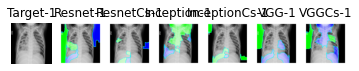

In [ ]:
T6Image1 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/person1954_bacteria_4886 (1).jpeg')
T6Image2 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/resnetwithoutCS.png')
T6Image3 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/resnetwithCS (1).png')
T6Image4 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/inceptionwithoutCS (1).png')
T6Image5 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/inceptionwithCS (1).png')
T6Image6 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/VGGwithoutCS (1).png')
T6Image7 = cv2.imread('/content/drive/MyDrive/ci/images (1)/target11 (1)/VGGwithCS (1).png')

plt.subplot(1, 7, 1)
plt.imshow(T6Image1)
plt.axis('off')
plt.title("Target-1")

plt.subplot(1, 7, 2)
plt.imshow(T6Image2)
plt.axis('off')
plt.title("Resnet-1")

plt.subplot(1, 7, 3)
plt.imshow(T6Image3)
plt.axis('off')
plt.title("ResnetCs-1")

plt.subplot(1, 7, 4)
plt.imshow(T6Image4)
plt.axis('off')
plt.title("Inception-1")

plt.subplot(1, 7, 5)
plt.imshow(T6Image5)
plt.axis('off')
plt.title("InceptionCs-1")

plt.subplot(1, 7, 6)
plt.imshow(T6Image6)
plt.axis('off')
plt.title("VGG-1")

plt.subplot(1, 7, 7)
plt.imshow(T6Image7)
plt.axis('off')
plt.title("VGGCs-1")
plt.show()
